In [2]:
import warnings
import pandas as pd
import plotly.express as px
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection
from upath import UPath as Path
import warnings
from aicsimageio import transforms, AICSImage
import nbvv
import os

20-Oct-22 00:33:18 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [3]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
df.set_index(df['CellId'].astype(int), inplace=True)
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


In [30]:
print(df.Structure.unique())
print(df.cell_stage.unique())
print([
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
])

['mitochondria' 'actin filaments' 'centrioles' 'microtubules'
 'nuclear envelope' 'desmosomes' 'ER (Sec61 beta)' 'Golgi'
 'nuclear speckles' 'gap junctions' 'plasma membrane' 'actomyosin bundles'
 'tight junctions' 'actin bundles' 'lysosomes' 'nucleoli (DFC)' 'histones'
 'matrix adhesions' 'nucleoli (GC)' 'nuclear pores' 'ER (SERCA2)'
 'adherens junctions' 'endosomes' 'peroxisomes' 'cohesins']
['M4M5' 'M0' 'M6M7_single' 'M1M2' 'M3' 'M6M7_complete']
['max_projection_x', 'max_projection_y', 'max_projection_z', 'mean_projection_x', 'mean_projection_y', 'mean_projection_z', 'median_projection_x', 'median_projection_y', 'median_projection_z', 'center_slice']


In [5]:
df.sample(1)['max_projection_x'].values

array(['s3://allencell-hipsc-cytodata/max_projection_x/361473.ome.tiff'],
      dtype=object)

/opt/conda/lib/python3.10/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


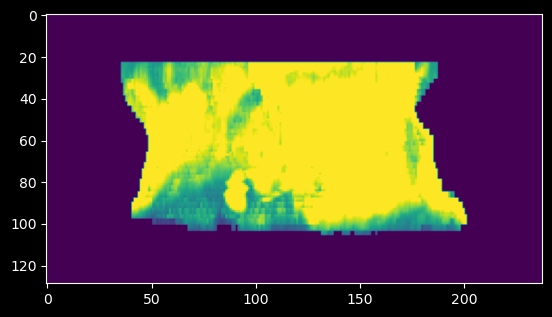

In [14]:
%matplotlib inline
img = AICSImage(df.sample(1)['max_projection_x'].values[0]).data.squeeze()

plt.imshow(img[2,:,:])

/opt/conda/lib/python3.10/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/opt/conda/lib/python3.10/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


Text(0.5, 1.0, 'Microtubules Maz_Z M0')

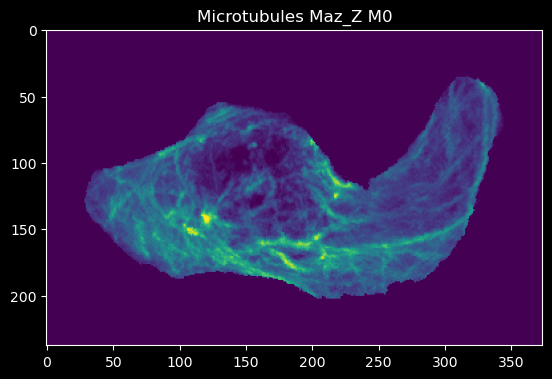

In [22]:
%matplotlib inline
############################################################
# cells with marked microtubules
df_microtubules = df[
    (df['Structure'] == "microtubules")
    # (df['cell_stage'] == "M0")
]

sample = df_microtubules.sample(1)
img = AICSImage(sample['max_projection_z'].values[0]).data.squeeze()

plt.imshow(img[3,:,:])
plt.title('Microtubules Maz_Z')

############################################################
# cells with marked microtubules & M0
df_microtubules_M0 = df[
    (df['Structure'] == "microtubules") &
    (df['cell_stage'] == "M0")
]

sample = df_microtubules_M0.sample(1)
img = AICSImage(sample['max_projection_z'].values[0]).data.squeeze()

plt.imshow(img[3,:,:])
plt.title('Microtubules Maz_Z M0')

############################################################
# structure volume
df_microtubules_M0 = df[
    (df['Structure'] == "microtubules") &
    (df['cell_stage'] == "M0")
]

sample = df_microtubules_M0.sample(1)
img = AICSImage(sample['max_projection_z'].values[0]).data.squeeze()

plt.imshow(img[3,:,:])
plt.title('Microtubules Maz_Z M0')

['bf', 'dna', 'membrane', 'structure', 'dna_segmentation', 'membrane_segmentation', 'struct_segmentation_roof']


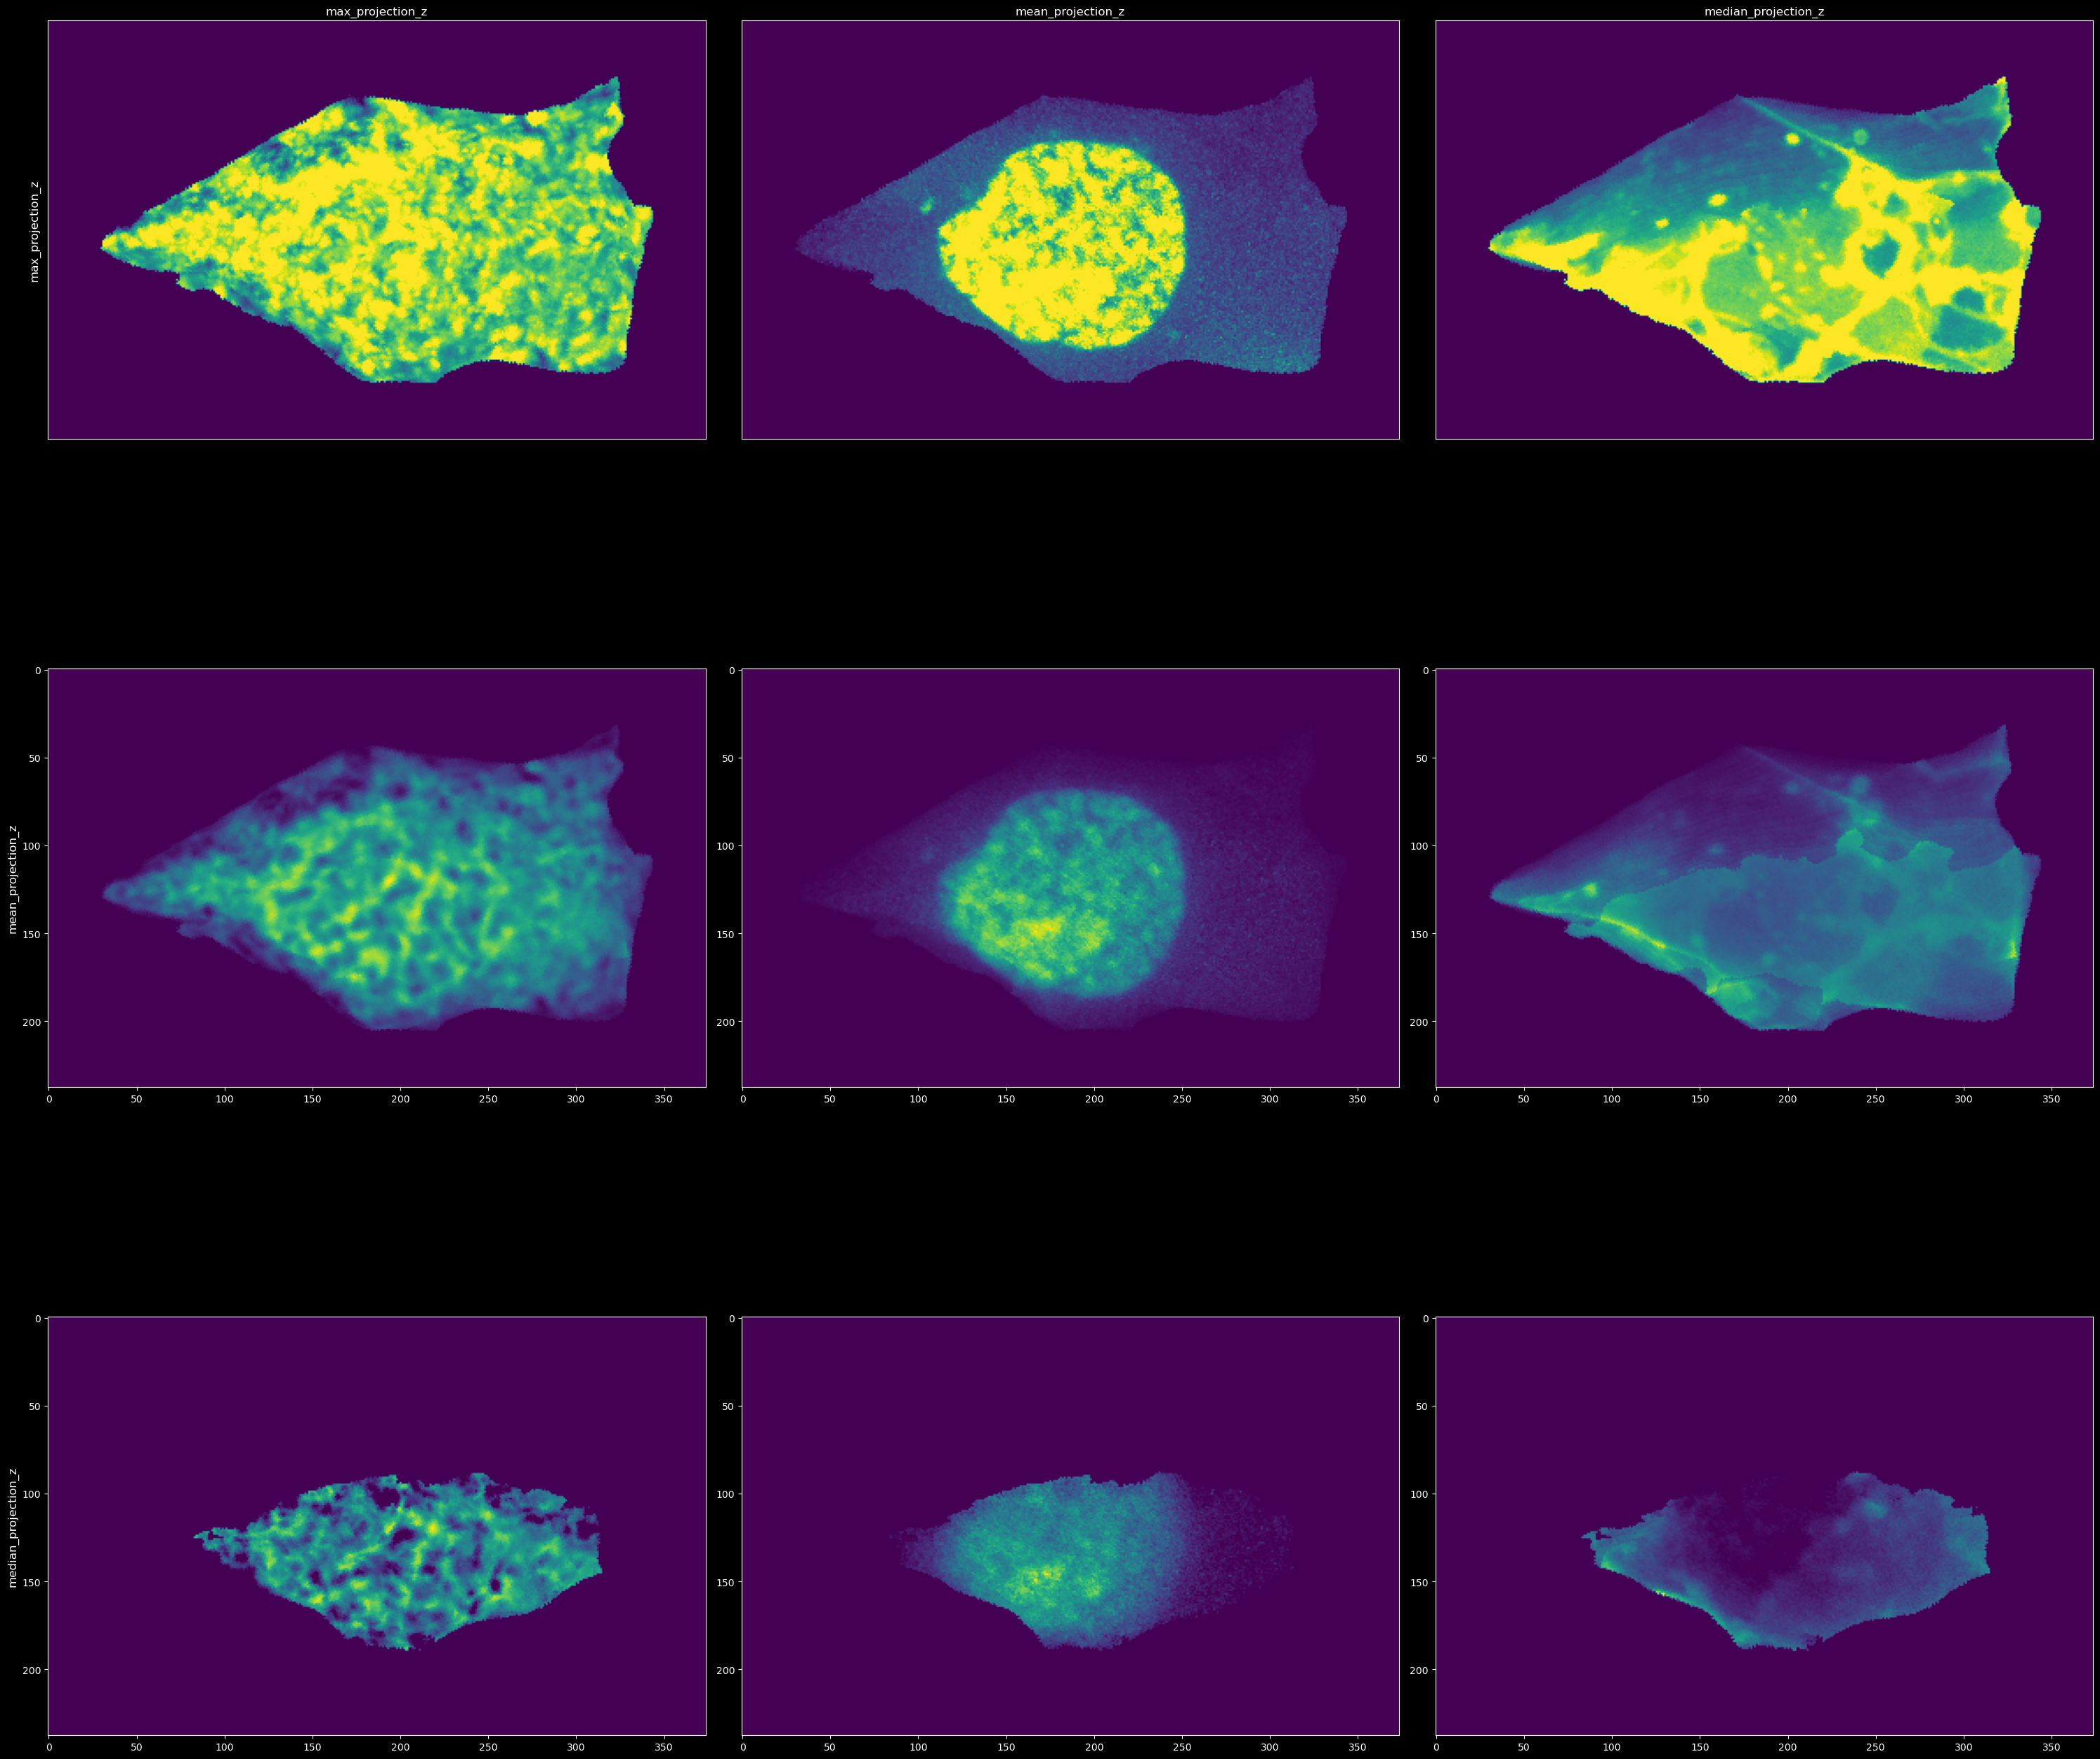

In [5]:
%matplotlib inline

df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
some_cell = df.sample(1).iloc[0]
full_img = read_ome_zarr(some_cell["3d_image"], level=2)
img_data = full_img.data.squeeze()

nbvv.volshow(
    img_data,
    spacing=[1,1,1],  # full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

projections = [
    'max_projection_z',
    'mean_projection_z',
    'median_projection_z',
   ]

print(full_img.channel_names)

f, axs = plt.subplots(len(projections), 3, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(projections):
        axs[proj_ix, ix].imshow(proj[ix])
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
            axs[proj_ix, ix].set_xticks([])
            axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()

In [ ]:
#subsetting data, code from Michiel
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

df_sub_fit = df[(df['fits_x']==True) &
               (df['fits_y']==True) &
               (df['fits_z']==True)
              ]

df_sub_fit_center = df_sub_fit[df_sub_fit['edge_flag'] == 0]
dataset = df_sub_fit_center.drop(df_sub_fit_center[df_sub_fit_center['cell_stage']=='M6M7_single'].index)